In [1]:
cd '/home/dpirvu/axion/'

/home/dpirvu/axion


In [2]:
import os,sys

print(sys.path)

#sys.path.remove('/home/dpirvu/DarkPhoton/hmvec-master')
sys.path.remove('/home/dpirvu/DarkPhotonxunWISE/hmvec-master')

sys.path.append('/home/dpirvu/axion/hmvec-master/')
sys.path.append('/home/dpirvu/python_stuff/')

print(sys.path)

import hmvec as hm

from plotting import *
from compute_power_spectra import *
from params import *

%matplotlib inline

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


['/home/dpirvu', '/cm/shared/apps/python/python37/lib/python37.zip', '/cm/shared/apps/python/python37/lib/python3.7', '/cm/shared/apps/python/python37/lib/python3.7/lib-dynload', '', '/home/dpirvu/.local/lib/python3.7/site-packages', '/home/dpirvu/DarkPhotonxunWISE/hmvec-master', '/cm/shared/apps/python/python37/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages/IPython/extensions', '/home/dpirvu/.ipython']
['/home/dpirvu', '/cm/shared/apps/python/python37/lib/python37.zip', '/cm/shared/apps/python/python37/lib/python3.7', '/cm/shared/apps/python/python37/lib/python3.7/lib-dynload', '', '/home/dpirvu/.local/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages', '/cm/shared/apps/python/python37/lib/python3.7/site-packages/IPython/extensions', '/home/dpirvu/.ipython', '/home/dpirvu/axion/hmvec-master/', '/home/dpirvu/python_stuff/']


In [3]:

TFIRAS   = 2.725     # in Kelvin
TCMB     = 2.726*1e6 # in micro Kelvin
cmMpc    = 3.2407792896e-25    # Mpc/cm            # how many Mpc in a cm
eVinvCm  = 1.97*1e-5  #1.2398419e-4        # cm/eV^-1          # how many cm in a eV^-1
mpcEVinv = 1./(cmMpc*eVinvCm)  # eV^-1/Mpc         # how many eV^-1 in a Mpc

mMWvir  = 1.3*1e12
rMWvir  = 287*1e-3
rEarth  = 8*1e-3
csMW = 10.72 # log10 c = 1.025 - 0.097 log10 (M / (10^12 /h solar masses)) # h = 0.68

msun   = 1.9891e30     # kg               # Sun mass
mprot  = 1.67262e-27   # kg               # Proton mass
m2eV   = 1.4e-21       # eV^2             # conversion factor for plasma mass (eq. (2) in Caputo et al; PRL)
ombh2  = 0.02225                 # Physical baryon density parameter Ωb h2
omch2  = 0.1198                  # Physical dark matter density parameter Ωc h2
conv   = m2eV*(ombh2/omch2)*(msun/mprot)*(cmMpc)**3.

thomson = 0.6652*1e-24
conv2 = thomson*(ombh2/omch2)*(msun/mprot)*(cmMpc)**2.

kB      = 8.61732814974493*1e-5   # Boltzmann constant in eV/Kelvin
K2eV    = lambda K: kB * K
cligth  = 299792458.0             # m/s
clight1 = 9.71561e-15             # Mpc/s

hplanck    = 6.62607015*1e-34     # not hbar!            # m2 kg / s     = Joule * second
kboltzmann = 1.380649*1e-23                              # m2 kg s-2 K-1 = Joule / Kelvin
xx0  = lambda nu: hplanck * nu*1e9 / kboltzmann / TFIRAS # for nu in GHz
xov0 = lambda nu: (1. - np.exp(-xx0(nu))) / xx0(nu)

xx  = lambda om: om / (kB * TFIRAS)      # for omega in eV
xov = lambda om: (1. - np.exp(-xx(om))) / xx(om)

frq = lambda nu: 100. * nu * cligth
BBf = lambda frq: 1e26/1e6 * (2.*frq**3.*hplanck)/cligth**2. / (np.exp(frq * hplanck/kboltzmann/TFIRAS) - 1.)

BBω = lambda omg: (omg**3.)/(2.*np.pi**2.) / (np.exp(omg/K2eV(TFIRAS)) - 1.)

aa = lambda z: 1./(1.+z)

arcmin2rad = lambda arcm: arcm/60. * np.pi/180.
ghztoev    = lambda GHz: 4.13566553853809E-06 * GHz
gauss2evsq = lambda gauss: 1.95e-2 * gauss


In [4]:
from scipy.optimize import minimize
from scipy.stats import chi2


### FIRAS constraint

In [5]:
COBE = np.genfromtxt('./data/FIRAS.txt')
print(np.shape(COBE))

COBE = COBE[:,:]
print(np.shape(COBE))


(43, 5)
(43, 5)


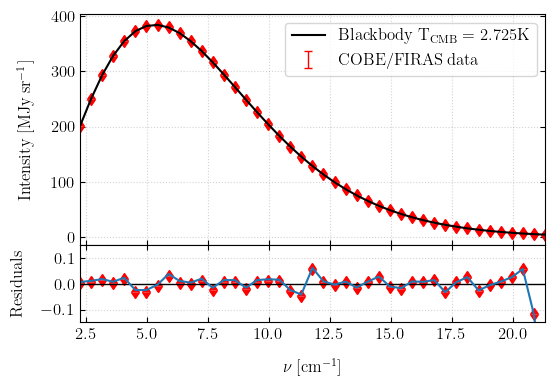

In [6]:
fig = plt.figure(figsize=(6,4))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex = ax0)

ax0.errorbar(COBE[:,0], COBE[:,1], yerr=COBE[:,3]*1e-3, color='k', ecolor='r', \
            capthick=1, linewidth=1, fmt='None', uplims=True, lolims=True, label=r'$\rm COBE/FIRAS \; data$')

# data minus residual = blackbody
ax0.plot(COBE[:,0], COBE[:,1]-COBE[:,2]*1e-3, color='k', label=r'$\rm Blackbody \; T_{\rm CMB} = 2.725K$')

ax1.errorbar(COBE[:,0], COBE[:,1]-BBf(frq(COBE[:,0])))

ax1.errorbar(COBE[:,0], COBE[:,2]*1e-3, yerr=COBE[:,3]*1e-3, color='k', ecolor='r', \
                        capthick=1, linewidth=1, fmt='None', uplims=True, lolims=True,)

ax0.set_ylabel(r'$\rm Intensity \; [MJy \; sr^{-1}]$')
ax1.set_xlabel(r'$\rm \nu \; [cm^{-1}]$')
ax1.set_ylabel(r'$\rm Residuals$')

ax1.axhline(0, ls='-', color='k', alpha=1, linewidth=1)
ax1.set_ylim((-0.15,0.15))
ax1.set_xlim((COBE[0,0],COBE[-1,0]))

plt.setp(ax0.get_xticklabels(), visible=False)
yticks = ax1.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)

ax0.tick_params(axis="y", direction="in")
ax0.tick_params(axis="x", direction="in")
ax1.tick_params(axis="y", direction="in")
ax1.tick_params(axis="x", direction="in")

ax0.yaxis.set_ticks_position('both')
ax0.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')

ax0.grid(ls=':', color='darkgray', alpha=0.5)
ax1.grid(ls=':', color='darkgray', alpha=0.5)
plt.subplots_adjust(hspace=.0)

ax0.legend()
plt.show()

/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


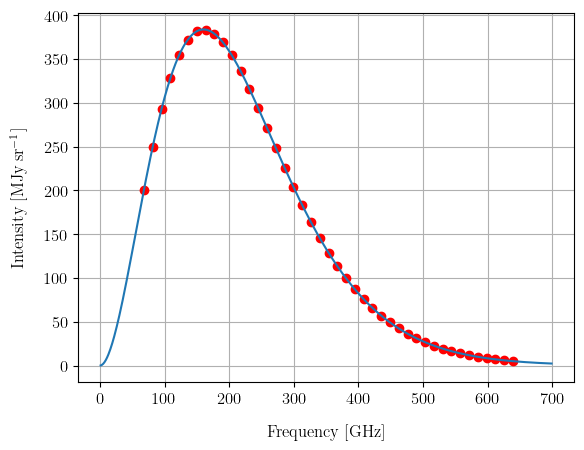

In [7]:
plt.plot(frq(COBE[:,0])/1e9, BBf(frq(COBE[:,0])), 'ro')

freqs = np.linspace(0, 699, 700)
plt.plot(freqs, BBf(freqs*1e9))
plt.xlabel(r'$\rm Frequency \; [GHz]$')
plt.ylabel(r'$\rm Intensity \; [MJy \; sr^{-1}]$')
plt.grid(); plt.show()


In [8]:
frq(COBE[:,0])/1e9

array([ 68.05288797,  81.54354858,  95.33400164, 108.82466225,
       122.31532286, 136.10577593, 149.59643654, 163.38688961,
       176.87755022, 190.36821083, 204.1586639 , 217.64932451,
       231.13998512, 244.93043819, 258.4210988 , 272.21155186,
       285.70221247, 299.19287308, 312.98332615, 326.47398676,
       339.96464737, 353.75510044, 367.24576105, 381.03621412,
       394.52687473, 408.01753534, 421.80798841, 435.29864902,
       448.78930963, 462.57976269, 476.0704233 , 489.86087637,
       503.35153698, 516.84219759, 530.63265066, 544.12331127,
       557.91376434, 571.40442495, 584.89508556, 598.68553863,
       612.17619924, 625.66685985, 639.45731291])

[6.80528880e+10 8.15435486e+10 9.53340016e+10 1.08824662e+11
 1.22315323e+11 1.36105776e+11 1.49596437e+11 1.63386890e+11
 1.76877550e+11 1.90368211e+11 2.04158664e+11 2.17649325e+11
 2.31139985e+11 2.44930438e+11 2.58421099e+11 2.72211552e+11
 2.85702212e+11 2.99192873e+11 3.12983326e+11 3.26473987e+11
 3.39964647e+11 3.53755100e+11 3.67245761e+11 3.81036214e+11
 3.94526875e+11 4.08017535e+11 4.21807988e+11 4.35298649e+11
 4.48789310e+11 4.62579763e+11 4.76070423e+11 4.89860876e+11
 5.03351537e+11 5.16842198e+11 5.30632651e+11 5.44123311e+11
 5.57913764e+11 5.71404425e+11 5.84895086e+11 5.98685539e+11
 6.12176199e+11 6.25666860e+11 6.39457313e+11]
[ 68.05288797  81.54354858  95.33400164 108.82466225 122.31532286
 136.10577593 149.59643654 163.38688961 176.87755022 190.36821083
 204.1586639  217.64932451 231.13998512 244.93043819 258.4210988
 272.21155186 285.70221247 299.19287308 312.98332615 326.47398676
 339.96464737 353.75510044 367.24576105 381.03621412 394.52687473
 408.01753534 

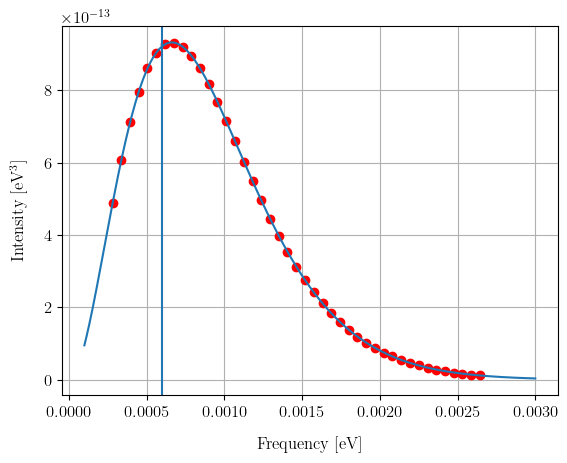

In [9]:
freqs = frq(COBE[:,0]) # Hz
print(freqs)
freqs = freqs/1e9 # GHz
print(freqs)
freqs = ghztoev(freqs) # eV
print(freqs)

plt.plot(freqs, BBω(freqs), 'ro')
plt.axvline(ghztoev(145))

freqsext = np.linspace(1e-4, 3e-3, 1000)
plt.plot(freqsext, BBω(freqsext))
plt.xlabel(r'$\rm Frequency \; [eV]$')
plt.ylabel(r'$\rm Intensity \; [eV^3]$')
plt.grid(); plt.show()


In [10]:
# we want the residual of the CMB blackbody to be greater than the screening due to dark photons
# res < ϵ^2 τav T0
firasdomainEV = ghztoev(frq(COBE[:,0])/1e9)

FIRASdata = np.zeros(np.shape(COBE))
for cind, col in enumerate([COBE[:,0], COBE[:,1], COBE[:,2], COBE[:,3], COBE[:,4]]):
    if cind==0:
        FIRASdata[:, cind] = firasdomainEV
    if cind==1:
        FIRASdata[:, cind] = col/(1e26/1e6*(2.*frq(COBE[:,0])**3.*hplanck)/cligth**2.) * firasdomainEV**3. / (2.*np.pi**2.)
    else:
        FIRASdata[:, cind] = col/(1e26/1e3*(2.*frq(COBE[:,0])**3.*hplanck)/cligth**2.) * firasdomainEV**3. / (2.*np.pi**2.)


In [11]:
loadedmasses, loadedGAS = np.load('./data/monopole.npy')

f = scp.interpolate.interp1d(loadedmasses, loadedGAS)
masss = np.geomspace(loadedmasses[0], loadedmasses[50], 100)
constraint = f(masss)
print(np.shape(constraint))

(100,)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


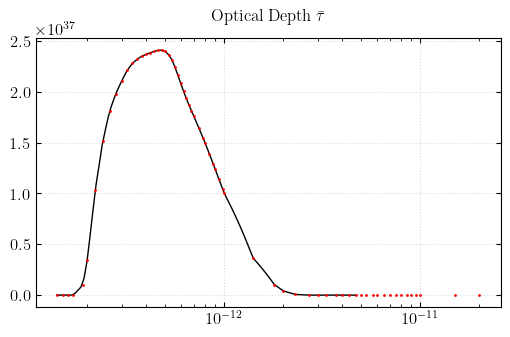

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6,3.5))
plt.title(r'$\rm Optical \; Depth \; \bar{\tau}$')
plt.plot(masss, constraint, 'k', lw=1)
plt.plot(loadedmasses, loadedGAS, 'ro', ms=1)
plt.xscale('log')
beautify(ax)
plt.show()


In [13]:
BBωT = lambda T, omg: (omg**3.)/(2. * np.pi**2.) / (np.exp(omg/K2eV(T)) - 1.)


In [14]:
eplist = np.geomspace(1.e-15, 1e-21, 50)


In [15]:
invNdof = 1./(len(COBE)-1)
Ndof = len(COBE)

chisqfid = lambda T:         invNdof * np.sum( ( (FIRASdata[:,1] - BBωT(T, firasdomainEV)                     )/FIRASdata[:,3])**2. )

chisq = lambda T, mi, ei: invNdof * np.sum( ( (FIRASdata[:,1] - BBωT(T, firasdomainEV)*(1. - scrGAS[mi,ei]))/FIRASdata[:,3])**2. )


In [16]:
scrGAS = np.zeros((len(masss), len(eplist), len(COBE)))
print(np.shape(scrGAS))

for mi, MA in enumerate(masss):
    for ei, epsilon in enumerate(eplist):
        scrGAS[mi,ei] = epsilon**2. * constraint[mi] * firasdomainEV


(100, 50, 43)


In [17]:
gofdataGAS, gofdattemp = np.zeros((2, len(masss), len(eplist)))

for mi, MA in enumerate(masss):
    for ei, epsilon in enumerate(eplist):
        resGAS = minimize(chisq, args=(mi, ei), x0=TFIRAS, method='Powell', tol=1e-15)
        gofdataGAS[mi,ei] = resGAS.fun
        gofdattemp[mi,ei] = resGAS.x



/cm/shared/apps/python/python37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


In [22]:
resnull = minimize(chisqfid, x0=TFIRAS, method='Powell', tol=1e-15)
print(TFIRAS, resnull.x, resnull.fun)

eind0 = np.argmin(np.abs(eplist - epsilon))
print(mind0, eind0, eplist[eind0], epsilon)

res = minimize(chisq, args=(mind0, eind0), x0=TFIRAS, method='Powell', tol=1e-15)
print(TFIRAS, res.x, res.fun)


2.725 [2.72501553] 1.0737243313348372
27 49 1e-21 1e-21
2.725 [2.72501554] 1.0737229993275228


In [23]:
# chisq = lambda T, a1, a2: invNdof * np.sum( ( (FIRASdata[:,1] - BBωT(T, firasdomainEV)*(1. - scrGAS(a1,a2)))/FIRASdata[:,3])**2. )

# scrGAS = lambda a1, a2: a1 * firasdomainEV + a2 * firasdomainEV**2.

# resGAS = minimize(chisq, args=(val_a1, val_a2), x0=TFIRAS, method='Powell', tol=1e-15)


1e-10


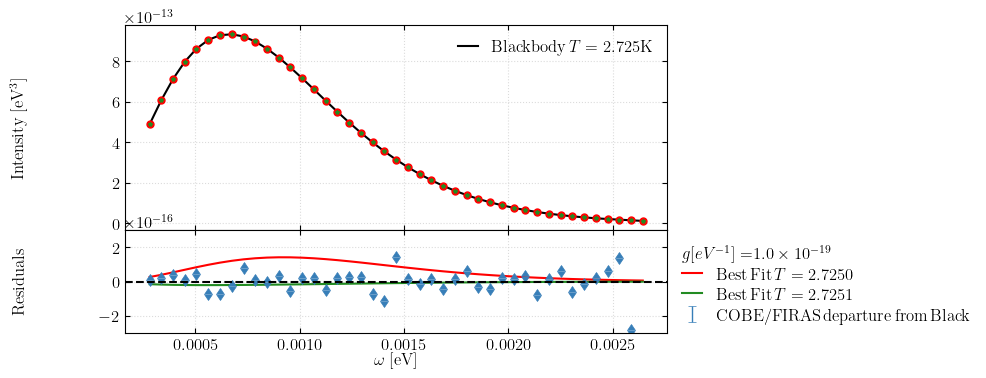

In [24]:
cych = ['#377eb8', '#ff7f00', 'forestgreen', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
fig = plt.figure(figsize=(7,4))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
plt.subplots_adjust(hspace=.0)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex = ax0)


mind0 = 27
epsilon0 = 1.e-19
eind0 = np.argmin(np.abs(eplist-epsilon0))
print(epsilon0 * 1e9)

screenedGAS     = BBωT(TFIRAS,                  firasdomainEV) * (1. - eplist[eind0]**2. * constraint[mind0] * firasdomainEV)
screenedGAStest = BBωT(gofdattemp[mind0,eind0], firasdomainEV) * (1. - eplist[eind0]**2. * constraint[mind0] * firasdomainEV)

δIGAS    = BBωT(TFIRAS, firasdomainEV) - screenedGAS
δIGAStest= BBωT(TFIRAS, firasdomainEV) - screenedGAStest

ax0.plot(firasdomainEV, FIRASdata[:,1], color='k', label=r'${\rm Blackbody \,} T=2.725 {\rm K}$')
ax0.plot(firasdomainEV, screenedGAS, color='r', ls='none', marker='o', ms=5)
ax0.plot(firasdomainEV, screenedGAStest, color='forestgreen', ls='none', marker='*', ms=3)


ax1.plot(firasdomainEV, δIGAS, color='r', label=r'${{\rm Best \, Fit \,}} T={:.4f}$'.format(TFIRAS))
ax1.plot(firasdomainEV, δIGAStest, color='forestgreen', label=r'${{\rm Best \, Fit \,}} T={:.4f}$'.format(gofdattemp[mind0,eind0]))

ax1.errorbar(firasdomainEV, FIRASdata[:,2], yerr=FIRASdata[:,3], color='k', ecolor=cych[0], \
                        capthick=0.5, linewidth=1, fmt='None', uplims=True, lolims=True, label=r'${\rm COBE/FIRAS \, departure \, from \, Black}$')
ax1.axhline(0, ls='--', color='k')
ax1.set_ylim((-3.e-16, 3.e-16))
ax1.set_xlabel(r'$\rm \omega \; [eV]$')
ax0.set_ylabel(r'$\rm Intensity \; [eV^3]$')
ax1.set_ylabel(r'$\rm Residuals$')
beautify(ax1, times=-120, bb=(1.,1.), ttl=r'$g [eV^{-1}] = $'+sci_notation(epsilon0))
beautify(ax0, times=-120)
#plt.tight_layout()
plt.savefig('./plots/blackbody_change.pdf')
plt.show()


3e-09


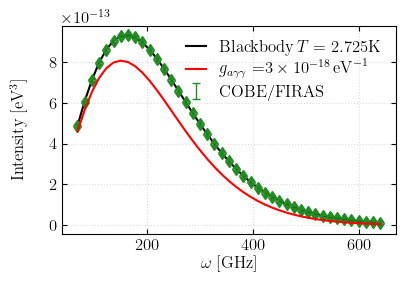

In [98]:
cych = ['#377eb8', '#ff7f00', 'forestgreen', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
fig, ax0 = plt.subplots(1, 1, figsize=(4.3,2.7))

mind0 = 27
epsilon0 = 3.e-18
print(epsilon0 * 1e9)

distGAS = BBωT(TFIRAS, firasdomainEV) * (1. - epsilon0**2. * constraint[mind0] * firasdomainEV)
δIGAS   = BBωT(TFIRAS, firasdomainEV) - distGAS

firasdomainGHz = frq(COBE[:,0])/1e9

ax0.plot(firasdomainGHz, FIRASdata[:,1], color='k', label=r'${\rm Blackbody \,} T=2.725 {\rm K}$')

ax0.errorbar(firasdomainGHz, BBω(firasdomainEV), yerr=FIRASdata[:,3], ls='None', marker='o', color='k', ms=0.001, ecolor='forestgreen', \
            capthick=1, lw=1, elinewidth=1, uplims=True, lolims=True, label=r'$\rm COBE/FIRAS$')

ax0.plot(firasdomainGHz, distGAS, color='r', label=r'$g_{a \gamma\gamma}=$'+sci_notation(epsilon0,0)+r'${\rm \, eV}^{-1}$')

ax0.set_xlabel(r'$\rm \omega \; [GHz]$')
ax0.set_ylabel(r'$\rm Intensity \; [eV^3]$')
beautify(ax0, times=-70)
plt.savefig('./plots/blackbody_change_nores.pdf')
plt.show()


In [ ]:
bound1 = chi2.ppf(q=0.95, df=Ndof)
bound2 = chi2.ppf(q=0.99, df=Ndof)
print(bound1, bound2)

x = masss
y = eplist
xx, yy = np.meshgrid(y, x)

contGAS95 = (gofdataGAS >= bound1)
contGAS99 = (gofdataGAS >= bound2)


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
im1 = ax[0].contour(xx, yy, contGAS95, levels=1, origin='lower', aspect='auto')
plt.colorbar(im1, ax=ax[0], label=r'$\chi^2$')
im1 = ax[1].contour(xx, yy, contGAS99, levels=1, origin='lower', aspect='auto')
plt.colorbar(im1, ax=ax[1], label=r'$\chi^2$')
for axx in ax:
    axx.set_xscale('log')
    axx.set_yscale('log')
beautify(ax)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
im1 = ax.imshow(gofdattemp, extent=[eplist[0],eplist[-1],masss[0],masss[-1]], origin='lower', aspect='auto')
plt.colorbar(im1, ax=ax, label=r'$T$')
ax.set_xscale('log')
ax.set_yscale('log')
beautify(ax)
plt.show()

In [ ]:
def find_first_one_index(arr):
    for i, val in enumerate(arr):
        if val:
            return i
    return -1  # Return -1 if no '1' is found


In [ ]:
fig, ax = plt.subplots(1,1, figsize = (4.5,3))

reio = contGAS99
coord, limit = np.zeros((2, len(masss)))
for mm, arr in enumerate(reio):
    first_true_index = find_first_one_index(arr[::-1])
    coord[mm] = masss[mm]
    limit[mm] = eplist[::-1][first_true_index]
l1, = plt.plot(coord, limit*1e9, label=r'$99\% \; \rm C.L.$')
np.save('./data/gas_contour.npy', [coord, limit])

reio = contGAS95
coord, limit = np.zeros((2, len(masss)))
for mm, arr in enumerate(reio):
    first_true_index = find_first_one_index(arr[::-1])
    coord[mm] = masss[mm]
    limit[mm] = eplist[::-1][first_true_index]
plt.plot(coord, limit*1e9, ls=':', label=r'$95\% \; \rm C.L.$')


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$g_{{\rm a}\gamma\gamma} \; [{\rm GeV^{-1}}]$')
ax.set_xlabel(r'$m_{\rm a} \; [{\rm eV}]$')
ymin, ymax = ax.get_ylim()
#ax.set_ylim((ymin, 1e-7))
beautify(ax, times=-200)
plt.savefig('./plots/gas_firascontour.pdf', rasterize=True)
plt.show()
